# Using Recurrent Neural Networks (RNN) for time series forecasting

In this activity we will use Recurernt Neural Networks (RNN) for time series foreacasting.
Remember that RNNs are suitable when we want to model data with sequential or temporal structures.

A "time series" is generally the observation of a variable over time, see https://en.wikipedia.org/wiki/Time_series for more details.
Time series forecasting is about making predictions about the future based on past data.
We will work on a relatively simple example, trying to predict Google stock prices (univariate time series), without getting into details on the statistics and math behind it.

For an overview of non-DeepLearning models for this task see [here](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)

Note that for rigorous time series analysis we would need other analysis than what is presented this notebook.

## Data Preprocessing

Upload the "Google_test.csv" and "Google_train.csv" datasets to your session before proceeding (both are posted on elearn).

You can easily download similar datasets as csv files for any Stock ticker from https://finance.yahoo.com/.

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Training data
Our training data is daily observations of Google stock price from *January 2010* till *January 2016*; 1529 observations over time

We will use only the **Opening** price values. Observations of a single variable over time is also called a univariate time series.
We try to predict future Opening prices based on its past values.

In [ ]:
dataset_train = pd.read_csv('Google_train.csv')
training_set = dataset_train.iloc[:, 1:2].values # use only Opening price as input data
dataset_train.head(2), dataset_train.tail(2)

(         Date        Open        High         Low       Close   Adj Close  \
 0  2010-01-04  312.304413  313.579620  310.954468  312.204773  312.204773   
 1  2010-01-05  312.418976  312.747742  309.609497  310.829926  310.829926   
 
     Volume  
 0  3927000  
 1  6031900  ,
             Date        Open        High         Low       Close   Adj Close  \
 1527  2016-01-28  722.219971  733.690002  712.349976  730.960022  730.960022   
 1528  2016-01-29  731.530029  744.989990  726.799988  742.950012  742.950012   
 
        Volume  
 1527  2676400  
 1528  3474300  )

In [ ]:
training_set

array([[312.304413],
       [312.418976],
       [311.761444],
       ...,
       [713.669983],
       [722.219971],
       [731.530029]])

### OPTIONAL alternative training data
Alternatively, you can use the "yfinance" library to directly pull stock data from yahoo finance using a company's ticker.
Uncomment the code and use it instead of the provided datasets.

If you use this section, also make sure to pull corresponding testing data (see **OPTIONAL alternative testing data** in TOC).

As is, it pulls the same dates for Google stock as in the provided dataset. You can experiment using other timeframes.

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
dataset_train=yf.download("GOOGL", start="2010-01-01", end="2016-01-30")
training_set=dataset_train[['Adj Close']].values #using adjusted closing prices
training_set.shape

[*********************100%***********************]  1 of 1 completed


(1529, 1)

### Scaling our data

In [ ]:
# As we now, we need to scale our dataet
# Feature Scaling using MinMax scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
len(training_set)

1529

### Specifying time window (time steps)
We will look at the time window of 60 past days (60 time steps) to make predictions for today.
Our model will learn the current value based on the past window.

This value can be tuned to potentially improve model performance depending on the available data.


In [ ]:
# Creating a data structure with 60 timesteps and 1 output
window=60 #change this value to try another window size

In [ ]:

# i.e., at each time t we look at the 60 time steps before, t-1, ...,t-60 (3 previous financial months)
X_train = [] #each observation contains the 60 prices on the 60 time points before t
y_train = [] #each observation is the stock price on time t
for i in range(window, len(training_set)): #(60,1529)
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

Our data has to be reshaped into a tensor (3d data structure) before we can feed it to a RNN.
The tensor that can be feed to a RNN has the following structure:
* number of observations = length of training data - window =1529-60
* number of time steps; size of time window
* number of variables/features = 1 for univariate time series

In [ ]:
# Reshaping the data so that it fits the format required for the RNN input layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# 3D data structure (tensor) allowing for more than 1 variable, (number of observations,number of time steps,1)
X_train.shape

(1409, 120, 1)

### Testing Data
Our test data is daily observations of Google stock price from *February 2016* till *April 2016*; 42 observations.


In [ ]:
dataset_test = pd.read_csv('Google_test.csv')
dataset_test.head(2), dataset_test.tail(2), len(dataset_test)

(         Date        Open        High         Low       Close   Adj Close  \
 0  2016-02-01  750.460022  757.859985  743.270020  752.000000  752.000000   
 1  2016-02-02  784.500000  789.869995  764.650024  764.650024  764.650024   
 
     Volume  
 0  5139200  
 1  6348100  ,
           Date        Open        High         Low       Close   Adj Close  \
 40  2016-03-30  750.099976  757.880005  748.739990  750.530029  750.530029   
 41  2016-03-31  749.250000  750.849976  740.940002  744.950012  744.950012   
 
      Volume  
 40  1782400  
 41  1718800  ,
 42)

### OPTIONAL alternative testing data
Use this to pull testing data if you have pulled your training data using the alternative option.

As is, it pull the same dates for Google as in the provided dataset.

In [ ]:
#import yfinance as yf
#dataset_test=yf.download("GOOGL", start="2016-02-01", end="2016-04-01")
#training_set=dataset_test[['Adj Close']].values #using adjusted closing prices
#training_set.shape

we process our test data similar to what we did for the training data above.

In [ ]:
# window=60
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - window:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = [] #each observation contains the 60 prices on the 60 time points before t
y_test = [] #each observation is the stock price on time t
for i in range(window, len(inputs)):
    X_test.append(inputs[i-window:i, 0])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
#let's make sure our datasets are shaped correctly before we proceed...
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)

(1409, 120, 1) (1409,) (42, 120, 1) (42,)


## Building the first RNN model with LSTM

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
print(tf.__version__)

2.11.0


We will build a network with
* an input layer
* two LSTM layers (each with 50 units)
* each followed by a dropout layer to precent overfitting on the training data (see notebook 7 for more details on Dropout).
* our ouput layer has 1 node



In [ ]:
# Initialisi#ng the RNN
ts= keras.Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# Notice we specify the input layer here as well using input_shape=(60,1)
ts.add(layers.GRU(units = 50, return_sequences = True, input_shape =(120,1) ))#(X_train.shape[1], X_train.shape[2])))
ts.add(layers.Dropout(0.2))  #randomly drops 20% of observations to avoid overfitting

# Adding a second LSTM layer and some Dropout regularisation
# Note that the "return_sequences=False (default value)" for the last RNN layer and True for previous layers
ts.add(layers.GRU(units = 50))
ts.add(layers.Dropout(0.2))

# Adding the output layer
ts.add(layers.Dense(units = 1))


In [ ]:
ts.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_54 (GRU)                (None, 120, 50)           7950      
                                                                 
 dropout_51 (Dropout)        (None, 120, 50)           0         
                                                                 
 gru_55 (GRU)                (None, 50)                15300     
                                                                 
 dropout_52 (Dropout)        (None, 50)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 51        
                                                                 
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# we use "Mean Squared Error" as our loss function
ts.compile(optimizer = 'adam', #can also try  optimizer='rmsprop'
           loss = 'mean_squared_error', # mean_absolute_error
           metrics=['MeanSquaredError', 'MeanAbsoluteError', 'MeanAbsolutePercentageError']) #MSE, MAE, MAPE

In [ ]:
# Fitting the RNN to the Training set
history_LSTM=ts.fit(X_train, y_train,
               epochs = 10, batch_size = 50,verbose=1,
               validation_data=(X_test,y_test))


Epoch 1/10
29/29 [==============================] - 11s 245ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1110 - mean_absolute_percentage_error: 97899.1641 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0369 - val_mean_absolute_percentage_error: 4.0987
Epoch 2/10
29/29 [==============================] - 5s 174ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0418 - mean_absolute_percentage_error: 28893.0059 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0307 - val_mean_absolute_percentage_error: 3.4470
Epoch 3/10
29/29 [==============================] - 5s 182ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 14964.0146 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0329 - val_mean_absolute_percentage_error: 3.6816
Epoch 4/10
29/29 [==============================] -

### Evaluating the LSTM network and making predictions
Visualizing the loss (MSE) as the model trains over several epochs

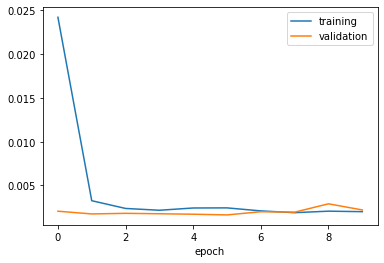

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_LSTM.history['loss'],label="training")
plt.plot(history_LSTM.history['val_loss'],label="validation")
plt.xlabel("epoch")
plt.legend()
plt.show()

### Question 1
Would improving the number of epochs (for training the model) improve the model fit? How do you know?

ANSWER: No, it doesn't improve the model fit because Although the validation loss does not decrease, the training loss does. This overfits the training set of data and there is no convergence of the two loses.

Let's predict the future stock prices and see how it compares with the actual prices

In [ ]:
real_stock_price = dataset_test.iloc[:, 1:2].values #outcome var=open price
len(real_stock_price)
#this is the number of future time units we will make predictions for

42

In [ ]:
predicted_stock_price = ts.predict(X_test)
# note that we need to inverse_transform the predicted values
# because the predictions are on the scaled [0,1] range (we MinMax scaled our data before training)
predicted_stock_price_LSTM = sc.inverse_transform(predicted_stock_price)

2/2 [==============================] - 1s 29ms/step


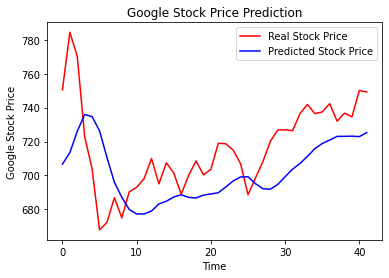

In [ ]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price_LSTM, color = 'blue', label = 'Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


### RMSE, MAE metrics for LSTM network
RMSE are MAE are both reasonable metrics to compare performance of forecasting models for time series (given the same data)

In [ ]:
from sklearn import metrics
import math
#print('Coefficients: \n', lin_reg.coef_) #regression coefficients
print("Root Mean squared error: %.2f" % math.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price_LSTM))) #RMSE
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(real_stock_price, predicted_stock_price_LSTM)) #MAE

Root Mean squared error: 26.23
Mean absolute error: 22.30


## Building another RNN model with GRUs

Let's build the same network using GRU cells instead of LSTM.

In [ ]:
# Initialisi#ng the RNN
ts2= keras.Sequential()

# Adding the first GRU layer and some Dropout regularisation
# Notice we specify the input layer here as well using input_shape=(60,1)
ts2.add(layers.GRU(units = 120, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
ts2.add(layers.Dropout(0.2))  #randomly drops 20% of observations to avoid overfitting

# Adding a second GRU layer and some Dropout regularisation
# Note that the "return_sequences=False (default value)" for the last RNN layer and True for previous layers
ts2.add(layers.GRU(units = 120))
ts2.add(layers.Dropout(0.2))

# Adding the output layer
ts2.add(layers.Dense(units = 1))

ts2.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_58 (GRU)                (None, 120, 120)          44280     
                                                                 
 dropout_55 (Dropout)        (None, 120, 120)          0         
                                                                 
 gru_59 (GRU)                (None, 120)               87120     
                                                                 
 dropout_56 (Dropout)        (None, 120)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 121       
                                                                 
Total params: 131,521
Trainable params: 131,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# we use "Mean Squared Error" as our loss function
ts2.compile(optimizer = 'adam', #can also try  optimizer='rmsprop'
           loss = 'mean_squared_error', # can also try mean_absolute_error
           metrics=['MeanSquaredError', 'MeanAbsoluteError', 'MeanAbsolutePercentageError']) #MSE, MAE, MAPE

In [ ]:
# Fitting the RNN to the Training set
history_GRU=ts2.fit(X_train, y_train,
               epochs = 10, batch_size = 50,verbose=1,
               validation_data=(X_test,y_test))

Epoch 1/10
29/29 [==============================] - 19s 486ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.0951 - mean_absolute_percentage_error: 38134.1445 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0259 - val_mean_absolute_percentage_error: 2.9377
Epoch 2/10
29/29 [==============================] - 13s 453ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 5436.7622 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0284 - val_mean_absolute_percentage_error: 3.1929
Epoch 3/10
29/29 [==============================] - 14s 480ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 13947.2578 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0257 - val_mean_absolute_percentage_error: 2.9170
Epoch 4/10
29/29 [==============================] 

### Evaluating the GRU network and making predictions



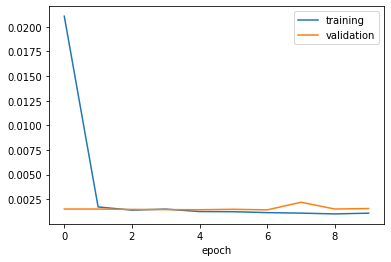

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_GRU.history['loss'],label="training")
plt.plot(history_GRU.history['val_loss'],label="validation")
plt.xlabel("epoch")
plt.legend()
plt.show()

###Question 2
Is this network overfitting the training data? How do you know?

ANSWER: We can state that the model is overfitting on training data if the training loss is decreasing but the validation loss is not.

In [ ]:
predicted_stock_price = ts2.predict(X_test)
# note that we need to inverse_transform the predicted values
# because the predictions are on the scaled [0,1] range (we MinMax scaled our data before training)
predicted_stock_price_GRU = sc.inverse_transform(predicted_stock_price)

2/2 [==============================] - 0s 42ms/step


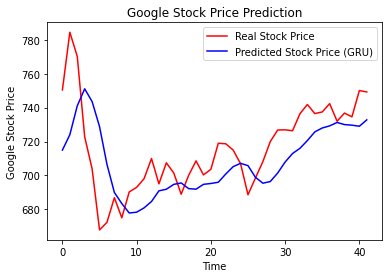

In [ ]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price_GRU, color = 'blue', label = 'Predicted Stock Price (GRU)')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

### RMSE, MAE metrics for GRU network

In [ ]:
print("Root Mean squared error: %.2f" % math.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price_GRU))) #RMSE
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(real_stock_price, predicted_stock_price_GRU)) #MAE

Root Mean squared error: 22.04
Mean absolute error: 17.35


##Comparing the LSTM and GRU models
Let's plot both models' predictions and the actual values

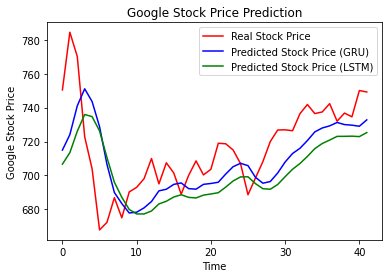

In [ ]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price_GRU, color = 'blue', label = 'Predicted Stock Price (GRU)')
plt.plot(predicted_stock_price_LSTM, color = 'green', label = 'Predicted Stock Price (LSTM)')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

### Question 3
Based on the above plot, which model seems to better forecast the future Opening prices?

ANSWER: GRU and LSTM models seems to better forecast the future opening prices.

In [ ]:
print("RMSE (LSTM): %.2f" % math.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price_LSTM))) #RMSE
print("MAE (LSTM): %.2f" % metrics.mean_absolute_error(real_stock_price, predicted_stock_price_LSTM)) #MAE

print("RMSE (GRU): %.2f" % math.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price_GRU))) #RMSE
print("MAE (GRU): %.2f" % metrics.mean_absolute_error(real_stock_price, predicted_stock_price_GRU)) #MAE

RMSE (LSTM): 26.23
MAE (LSTM): 22.30
RMSE (GRU): 22.04
MAE (GRU): 17.35


### Question 4
Which model has a better predictive performance? which metric did you use?

ANSWER: LSTM model has better predictive performance when we use MAE metric or RMSE metric.

## Can we improve the model?

There are several approaches we can try to potentially improve forecasting accuracy, including:

* trying a deeper model with more layers and/or units in each layer
* We can specify a longer time window for the network to learn from (for example 100 instead of 60).
* Adjusting the Dropout rate. Pay attention to overfitting when using smaller dropout rates (the 20% we used is a common middle ground)

We will try the first approach first

## Third model with 4 hidden layers

Let's try a model with 4 LSTM layers (same number of units in each layer), and same Dropout rate after each layer.

In [ ]:
# Initialisi#ng the RNN
ts3= keras.Sequential()

# Adding the first LSTM layer and some Dropout regularisation
ts3.add(layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
ts3.add(layers.Dropout(0.2))  #randomly drops 20% of observations to avoid overfitting

# Adding a second LSTM layer and some Dropout regularisation
ts3.add(layers.LSTM(units = 50, return_sequences = True))
ts3.add(layers.Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
ts3.add(layers.LSTM(units = 50, return_sequences = True))
ts3.add(layers.Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
ts3.add(layers.LSTM(units = 50))
ts3.add(layers.Dropout(0.2))

# Adding the output layer
ts3.add(layers.Dense(units = 1))

ts3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)               

In [ ]:
# we use "Mean Squared Error" as our loss function
ts3.compile(optimizer = 'adam', #can also try  optimizer='rmsprop'
           loss = 'mean_squared_error', # can also try mean_absolute_error
           metrics=['MeanSquaredError', 'MeanAbsoluteError', 'MeanAbsolutePercentageError'])

In [ ]:
# Fitting the model to the Training set
history_3=ts3.fit(X_train, y_train,
               epochs = 15, batch_size = 30,verbose=1,
               validation_data=(X_test,y_test));

Epoch 1/15
49/49 [==============================] - 18s 197ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.0880 - mean_absolute_percentage_error: 140858.7344 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0494 - val_mean_absolute_percentage_error: 5.4108
Epoch 2/15
49/49 [==============================] - 7s 148ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0454 - mean_absolute_percentage_error: 28955.2344 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 4.8494
Epoch 3/15
49/49 [==============================] - 8s 170ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 33934.9062 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0409 - val_mean_absolute_percentage_error: 4.6840
Epoch 4/15
49/49 [==============================] 

### Evaluating the 3rd model

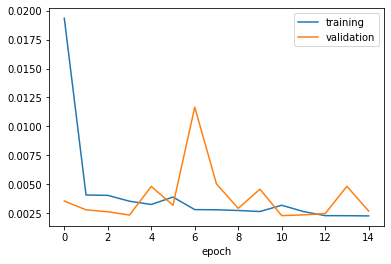

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_3.history['loss'],label="training")
plt.plot(history_3.history['val_loss'],label="validation")
plt.xlabel("epoch")
plt.legend()
plt.show()

2/2 [==============================] - 2s 28ms/step


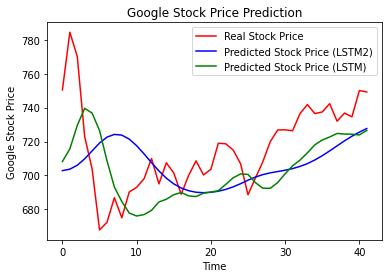

In [ ]:
predicted_stock_price = ts3.predict(X_test)
predicted_stock_price_3 = sc.inverse_transform(predicted_stock_price)

# Visualising the results
# you can add the plot for previous models' predictions by uncommenting the correspoding lines below
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price_3, color = 'blue', label = 'Predicted Stock Price (LSTM2)')
#plt.plot(predicted_stock_price_GRU, color = 'yellow', label = 'Predicted Stock Price (GRU)')
plt.plot(predicted_stock_price_LSTM, color = 'green', label = 'Predicted Stock Price (LSTM)')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [ ]:
print("Root Mean squared error: %.2f" % math.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price_3))) #RMSE
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(real_stock_price, predicted_stock_price_3)) #MAE


Root Mean squared error: 28.94
Mean absolute error: 23.46


###Question 5
Does the new model with 4 LSTM layers have a better performance?

ANSWER: No, new model with 4 LSTM layers does not have a better performance.

By adding more layers we are building a more complex model, which can be helpful (to improve model performance) if the additional complexity helps capturing the underlying complexity in our data.In the current example, forecasting a univariate time series, this does not seem to be the case.

## Changing window size (number of time steps)

Let's try increasing the window size to 120 (number of time steps). This means we will use the opening price from the past 120 days to predict the value of today's opening price.

To do that go to section **Specifying time window (time steps)** and change the value for *window* (first cell in the section) to **window=120** (from 60).
Rerun all the subsequent cells in the **Data Preprocessing** section to reshape the data with the new time window.

Then, rerun the first (LSTM network with 2 layers) and second (GRU network with 2 layers) model. *Run the following cell to keep the performance metrics for the two models (based on window=60) before changing the window size and retraining the models*.

In [ ]:
print("RMSE (LSTM):%.2f" % math.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price_LSTM)) +";",
      "MAE (LSTM):%.2f" % metrics.mean_absolute_error(real_stock_price, predicted_stock_price_LSTM)) #MAE

print("RMSE (GRU):%.2f" % math.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price_GRU))+";",
      "MAE (GRU):%.2f" % metrics.mean_absolute_error(real_stock_price, predicted_stock_price_GRU)) #MAE

RMSE (LSTM):25.29; MAE (LSTM):21.34
RMSE (GRU):25.74; MAE (GRU):21.90


###Question 6
Does increasing the window size improve the predictive performance for any of the 2 models?

Which one(s)?

ANSWER: Increasing the window size improves the GRU model's performance.
Increasing the window size doesn't improve the LSTM model's performance.

###Question 7 (Bonus question)
Do you think reducing the window size (e.g., from 60 to 30) could improve model's forecasting performance (i.e., in terms of RMSE or MAE)? why?


ANSWER: Reducing the window size improves the performance of LSTM model and GRU model.
